# **Inscribed square problem with Xpress NonLinear and Xpress Global**

***inscribed_square.ipynb***

This example shows how to use FICO&reg; Xpress NonLinear (SLP) or FICO&reg; Xpress Global to solve an instance of the inscribed square problem.

<!--*This example requires a license for the FICO&reg; Xpress Global solver. Click on [this link](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) for more information about trial and licensing options.*-->

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

The inscribed square problem, also known as the square peg problem or the Toeplitz' conjecture, is an unsolved question in geometry: Does every plane simple closed curve contain all four vertices of some square? The problem was proposed by [Otto Toeplitz in 1911](https://en.wikipedia.org/wiki/Inscribed_square_problem).
The next example is a special instance of the problem, and computes a **maximal inscribing square** for the curve defined by: 

$$(\sin(t) \cdot \cos(t), \sin(t) \cdot t), t \in [-\pi,\pi]$$

[Source in MINLPLIB](https://www.minlplib.org/inscribedsquare01.html)

The problem is formulated using decision variables $t_i, \forall i = 1..4$, with values in the range $[-\pi,\pi]$, corresponding to the four values of the parameter $t$. Then, $x$ and $y$ are the coordinates of the first corner of the square, while ($a, b$) is a vector pointing to a second vertex. The remaining vertices are given by combining $x, y, a, b$. The length of the vector ($a, b$) is exactly the side length of the square, which we aim at maximizing.

The first two constraints define $x$ and $y$ as the coordinates of the first point:
$$
\begin{array}{llll}
& \qquad \sin(t_1) \cdot \cos(t_1) = x \\
& \qquad \sin(t_1) \cdot t_1 = y \\
\end{array}
$$

The next two constraints define the coordinates of the second vertex by adding the pointed vector ($a$, $b$) to the first point ($x$, $y$):
$$
\begin{array}{llll}
& \qquad \sin(t_2) \cdot \cos(t_2) = x + a\\
& \qquad \sin(t_2) \cdot t_2 = y + b \\
\end{array}
$$

The remaining four constraints make sure that we define a square by defining its remaining two vertices as combinations of ($x$, $y$) and the vector ($a$, $b$):
$$
\begin{array}{llll}
& \qquad \sin(t_3) \cdot \cos(t_3) = x - b \\
& \qquad \sin(t_3) \cdot t_3 = y + a \\
& \qquad \sin(t_4) \cdot \cos(t_4) = x + a - b \\
& \qquad \sin(t_4) \cdot t_4 = y + a + b \\
\end{array}
$$

The objective is to maximize the length of one (or each) side of the square:
$$
\begin{array}{llll}
& \qquad \max a^2 + b^2
\end{array}
$$

In [ ]:
import xpress as xp
import math
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple

p = xp.problem()

# Add the variables, note that we force the first point to have positive x- and y-coordinates to break symmetry.
x1 = p.addVariable(name='x1', lb=-math.pi, ub=math.pi)
x2 = p.addVariable(name='x2', lb=-math.pi, ub=math.pi)
x3 = p.addVariable(name='x3', lb=-math.pi, ub=math.pi)
x4 = p.addVariable(name='x4', lb=-math.pi, ub=math.pi)
x5 = p.addVariable(name='x5')
x6 = p.addVariable(name='x6')
x7 = p.addVariable(name='x7')
x8 = p.addVariable(name='x8')

# Set initial values for the local solvers.
p.nlpSetInitVal([x1, x2, x4, x5, x6, x7, x8], [-math.pi, -math.pi/2, math.pi/2, 0, 0, 1, 1])

# The first two constraints define x5 and x6 as the coordinates of the first point.
p.addConstraint(xp.sin(x1) * xp.cos(x1) - x5 == 0)
p.addConstraint(xp.sin(x1) * x1 - x6 == 0)
# The next two constraints define x7 and x8 as the pointed vector from the first to the second point.
p.addConstraint(xp.sin(x2) * xp.cos(x2) - x5 -x7 == 0)
p.addConstraint(xp.sin(x2) * x2 - x6 -x8 == 0)
# The remaining four constraints make sure that we define a square by comparing vectors between the remaining points.
p.addConstraint(xp.sin(x3) * xp.cos(x3) - x5 + x8 == 0)
p.addConstraint(xp.sin(x3) * x3 - x6 - x7 == 0)
p.addConstraint(xp.sin(x4) * xp.cos(x4) - x5 - x7 + x8 == 0)
p.addConstraint(xp.sin(x4) * x4 - x6 - x7 - x8 == 0)

# The objective is to maximize the length of one (or each) side of the square.
p.setObjective(x7**2 + x8**2, sense=xp.maximize)

# Choose between solving with a local or global solver.
p.controls.nlpsolver = xp.constants.NLPSOLVER_LOCAL
# Choose between solving with SLP or Knitro.
p.controls.localsolver = xp.constants.LOCALSOLVER_XSLP

p.optimize()


The specific nonlinear solver can be chosen using the [NLPSOLVER](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/nonlinear/HTML/XSLP_NLPSOLVER.html) control:
  - Setting a value of "1" will invoke a local solver, with it being either SLP or Knitro (**if a license is available. The community license does not include Knitro**). 
  - The control defaults to -1, which has Xpress choose the most appropriate solver. If there are user functions or multi-start jobs, or if there is no license available for Xpress Global, a local solver will be called. In all other cases, Xpress Global will be used to solve the problem.

If a local solve is invoked, the [LOCALSOLVER](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/nonlinear/HTML/XSLP_SOLVER.html) control specify if either SLP or Knitro should be used by setting the control to "1" or "2" respectively. For convex QPs, setting the value to "2" will set Xpress Optimizer to solve the problem. By default (-1), an automatic selection is made based on model characteristics and solver availability.

By running the previous code cell below with the NLPSOLVER control equal to 1, SLP or Knitro will be called and the problem is solved to local optimality. This can be confirmed by running the code cell again with NLPSOLVER equal to 2, which finds a larger (maximal) square.


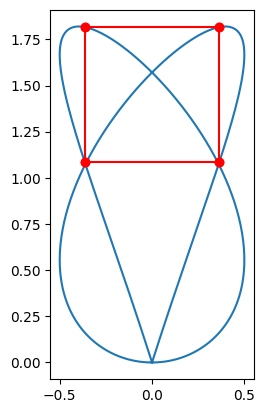

solution: x1: -2.7325955676531377 , x2: -1.9797934127315524 , x3: 2.7325955676531377 , x4: 1.9797934127315524 , x5: 0.3648880884756273 , x6: 1.0867243481340831 , x7: 0.0 , x8: 0.7297761769512545


In [2]:
# Visualize solution.
Point = namedtuple('Point', 'x y')

def get_coords(t):

  x = np.sin(t) * np.cos(t)
  y = np.sin(t) * t
  return Point(x, y)

# Below code approximates the graph of the function.
t = np.arange(-math.pi, math.pi, 0.01)
xs = np.sin(t) * np.cos(t)
ys = np.sin(t) * t

# Compute the x- and y-coordinates of the four vertices of the square.
v1 = get_coords(p.getSolution(x1))
v2 = get_coords(p.getSolution(x2))
v3 = get_coords(p.getSolution(x3))
v4 = get_coords(p.getSolution(x4))

# Plot the graph and the square.
fig, ax = plt.subplots()
cells = ax.plot(xs, ys)
plt.plot([v1.x, v2.x], [v1.y, v2.y], 'ro-')
plt.plot([v2.x, v4.x], [v2.y, v4.y], 'ro-')
plt.plot([v4.x, v3.x], [v4.y, v3.y], 'ro-')
plt.plot([v3.x, v1.x], [v3.y, v1.y], 'ro-')

ax.set_aspect('equal', adjustable='box')

plt.show()

# Print the solution values for variables.
print('solution: x1:', p.getSolution(x1), ', x2:', p.getSolution(x2), ', x3:', p.getSolution(x3), ', x4:', p.getSolution(x4), 
      ', x5:', p.getSolution(x5), ', x6:', p.getSolution(x6), ', x7:', p.getSolution(x7), ', x8:', p.getSolution(x8))